In [50]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random


In [51]:
df_train = pd.read_csv('../../data/sign_mnist_train.csv')
df_test = pd.read_csv('../../data/sign_mnist_test.csv')

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [52]:
y_train = df_train['label'].values
X_train = df_train.drop('label', axis=1).values

y_test = df_test['label'].values
X_test = df_test.drop('label', axis=1).values

In [76]:
# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

In [78]:
# Verification des taille des données
print(len(X_train))
print(len(X_test))

# Verification de la normalisation
print(X_train[0])

27455
7172
[0.41960784 0.4627451  0.49803922 0.5254902  0.54509804 0.56078431
 0.57254902 0.58823529 0.6        0.61176471 0.61960784 0.62745098
 0.63921569 0.64705882 0.62352941 0.65098039 0.65882353 0.66666667
 0.66666667 0.67058824 0.67058824 0.67058824 0.6745098  0.67058824
 0.67058824 0.66666667 0.66666667 0.6627451  0.43529412 0.4745098
 0.50588235 0.52941176 0.55294118 0.56470588 0.58039216 0.59215686
 0.60392157 0.61568627 0.62745098 0.63921569 0.64313725 0.66666667
 0.46666667 0.59607843 0.67058824 0.67058824 0.66666667 0.67058824
 0.6745098  0.6745098  0.6745098  0.6745098  0.6745098  0.67058824
 0.67058824 0.66666667 0.44313725 0.48235294 0.51372549 0.5372549
 0.55686275 0.56862745 0.58823529 0.59607843 0.60784314 0.61960784
 0.63137255 0.63921569 0.64313725 0.6745098  0.41176471 0.55686275
 0.66666667 0.67058824 0.67058824 0.67058824 0.6745098  0.6745098
 0.67843137 0.67843137 0.6745098  0.67058824 0.67058824 0.67058824
 0.45490196 0.49019608 0.52156863 0.54509804 0.5607843

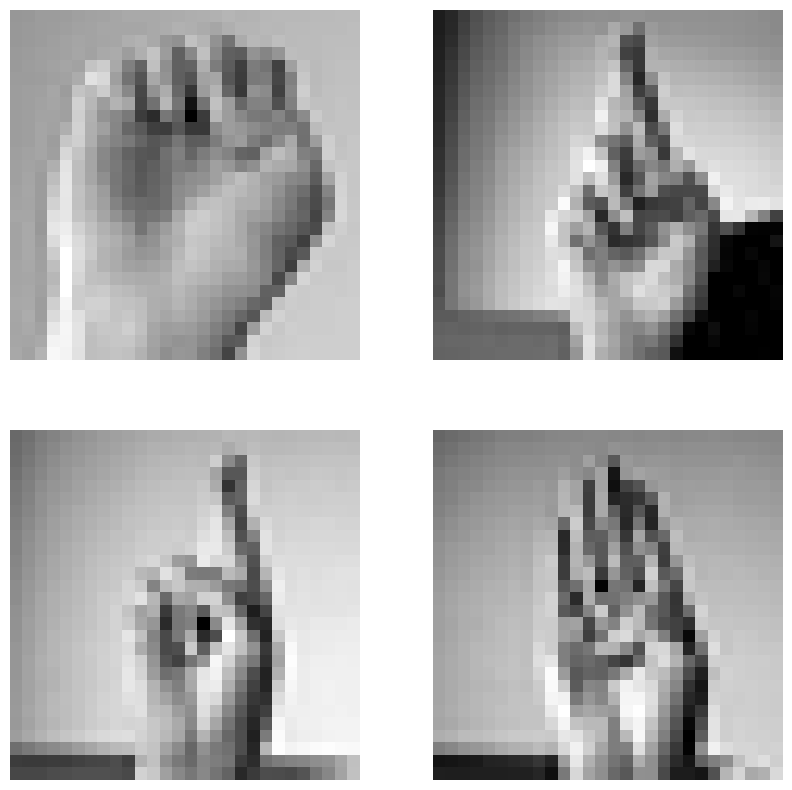

In [79]:
# Afficher 4 images aléatoires

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(X_train[random.randint(0, len(X_train))].reshape(28, 28), cmap=cm.gray)
        ax[i, j].axis('off')
plt.show()



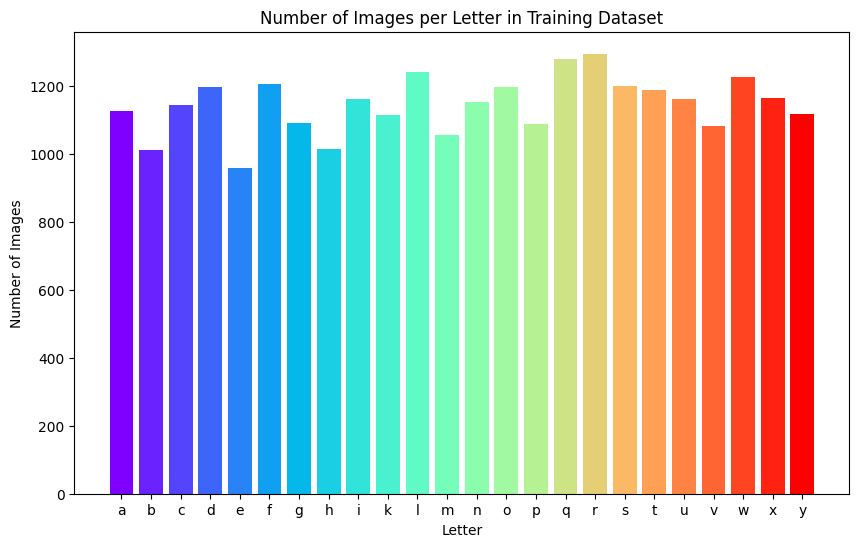

In [80]:
# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for label in y_train:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()


In [81]:
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

In [82]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [83]:
import torch.nn as nn

def evaluate(model, dataloader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss / len(dataloader), correct / total

In [8]:
def fit(model, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 15
    model.train()
    for epoch in range(epochs):
        correct = 0
        for batch_id , (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = loss_fn(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Compte le nombre de prédictions correctes
            prediction = torch.max(output.data, 1)[1] 
            correct += (prediction == var_y_batch).sum()
            if batch_id % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_id*len(X_batch), len(train_loader.dataset), 100.*batch_id / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_id+1))))
            # if float(correct*100) / float(BATCH_SIZE*(batch_id+1)) > 90:
            #     break
        history['train_loss'].append(loss)
        history['train_acc'].append(float(correct) / float(len(train_loader.dataset)))
        test_loss, test_acc = evaluate(model, test_loader)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)



In [58]:
def fit(model, train_loader, test_loader):
    """
    Entraîne le modèle sur les données d'entraînement et évalue les performances sur les données de test à chaque époque.

    Args:
        model (torch.nn.Module): Le modèle à entraîner.
        train_loader (torch.utils.data.DataLoader): Le chargeur de données pour les données d'entraînement.
        test_loader (torch.utils.data.DataLoader): Le chargeur de données pour les données de test.
    """

    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 15

    model.train()

    for epoch in range(epochs):
        train_loss = 0.0
        correct = 0
        for batch_id, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            # Compte le nombre de prédictions correctes
            prediction = torch.argmax(output, dim=1)
            correct += (prediction == y_batch).sum().item()

            train_loss += loss.item()

            if batch_id % 50 == 0:
                print(f'Epoch: {epoch + 1} [{batch_id * len(X_batch)}/{len(train_loader.dataset)}'
                      f' ({100. * batch_id / len(train_loader):.0f}%)]\tLoss: {train_loss / (batch_id + 1):.6f}')

        # Enregistrement des performances d'entraînement
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(correct / len(train_loader.dataset))

        # Évaluation du modèle sur les données de test
        test_loss, test_acc = evaluate(model, test_loader)

        # Enregistrement des performances de test
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f'\tAccuracy (train/test): {history["train_acc"][-1]:.3f}%'
              f'/{history["test_acc"][-1]:.3f}%\tTest Loss: {test_loss:.6f}')

    return history


In [59]:
# Nous devons redimensionner les données pour les passer dans le réseau de neurones convolutif
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# charge les données dans le DataLoader de PyTorch
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

#### Augmentation des données

In [60]:
data_transforms = v2.Compose([
    v2.RandomRotation(degrees=10),
    #v2.RandomPerspective(distortion_scale=0.2),
    v2.RandomHorizontalFlip(p=0.5), 
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Zoom et translation aléatoires
    # Modifie le contraste de maniere aleatoire
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # Modifie la luminosite de maniere aleatoire
    v2.RandomGrayscale(p=0.1),
    #v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.225])
])

In [61]:
percentage_of_augmented_data = 100 # 100 to double the amount of data
random_integers = random.sample(range(torch_X_train.size()[0]), int((percentage_of_augmented_data)/100*torch_X_train.size()[0]))


# Créer une liste pour stocker les nouveaux objets
new_images = []
new_labels = []

# Parcourir les indices aléatoires
for i in random_integers:
    img = torch_X_train[i]
    transformed_img = data_transforms(img)
    
    # Ajouter l'image transformée à la liste
    new_images.append(transformed_img.unsqueeze(0))
    
    # Ajouter l'étiquette correspondante à la liste
    new_labels.append(torch_y_train[i].unsqueeze(0))

print(torch_X_train.size())
# Concaténer les nouvelles images et étiquettes avec les données d'origine
if new_images:
    new_images = torch.cat(new_images, dim=0)
    new_labels = torch.cat(new_labels, dim=0)

    torch_X_train = torch.cat((torch_X_train, new_images), dim=0)
    torch_y_train = torch.cat((torch_y_train, new_labels), dim=0)

print(torch_X_train.size())

torch.Size([27455, 1, 28, 28])
torch.Size([54910, 1, 28, 28])


In [62]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
# Vérifier la taille de train
train_size = len(train)
print("Taille de train : ", train_size)


In [74]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 75, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(75, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(p=0.2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv4 = nn.Conv2d(32, 25, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(8*3*3, 512)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(512, 25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.pool4(x)

        x = x.view(-1, 8*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

cnn = ConvNet()
print(cnn)


ConvNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [71]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

In [72]:
fit(cnn,train_loader, test_loader)

RuntimeError: Given input size: (8x1x1). Calculated output size: (8x0x0). Output size is too small

In [16]:
evaluate(cnn, test_loader)

(0.9500787711588211, 0.9415783602900167)

In [17]:
# Convertir les listes en listes de nombres

# print(history['train_loss'])
history['train_loss'] = [i.item() for i in history['train_loss']]
# print(history['train_loss'])
# history['test_loss'] = [i.item() for i in history['test_loss']]
# history['train_acc'] = [i for i in history['train_acc']]
# history['test_acc'] = [i for i in history['test_acc']]


AttributeError: 'float' object has no attribute 'item'

In [22]:
print(history['train_loss'])
print(history['test_loss'])
print(history['train_acc'])
print(history['test_acc'])


[1.6994833946228027, 1.8065822124481201, 1.025024652481079, 1.1896862983703613, 1.8467295169830322, 1.8095182180404663, 1.658311128616333, 1.6696693897247314, 2.0830771923065186, 0.8797569274902344, 1.905656337738037, 0.9611898064613342, 1.7483688592910767, 1.5298364162445068, 1.4549959897994995]
[0.29136780589198075, 0.22784294178844397, 0.38970554416776093, 0.38022537940906154, 0.6590242107419504, 0.5342683244759165, 0.7579499656893313, 0.40937098263694166, 0.4759532987874282, 0.5235607682072411, 0.3787445131904997, 0.484968275352594, 0.5425509350042558, 0.5932960689447585, 0.9500787711588211]
[0.4678382808231652, 0.5223638681478784, 0.5259515570934256, 0.5254416317610635, 0.5280458932799126, 0.5309597523219814, 0.534201420506283, 0.535530868694227, 0.5371152795483518, 0.5369149517392097, 0.5397741759242397, 0.5417592423966491, 0.543616827535968, 0.5467128027681661, 0.5448734292478601]
[0.9043502509760178, 0.9532905744562187, 0.9390686001115449, 0.9065811489124372, 0.8855270496374791

In [23]:
save_model(cnn, 'model_160524.pth')

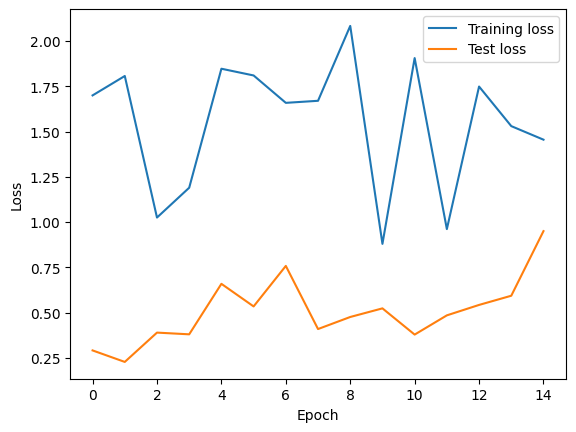

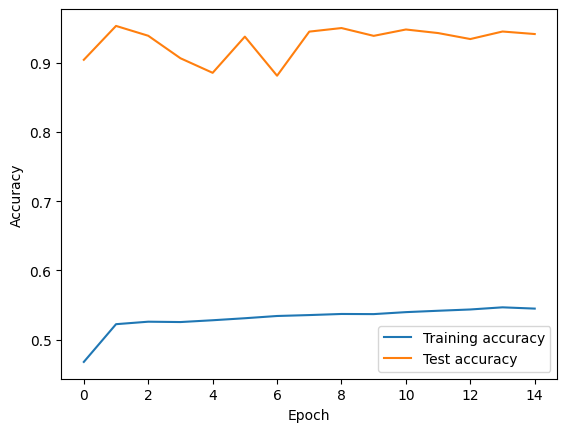

In [27]:
# Afficher la perte d'entraînement et de test
plt.figure()
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['test_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer la précision d'entraînement et de test
plt.figure()
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['test_acc'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
def evaluate2(model, data_loader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
    test_loss /= len(data_loader.dataset)
    test_acc = 100 * correct / len(data_loader.dataset)
    return test_loss, test_acc

evaluate2(cnn, test_loader, 'cpu')

(0.029805873328323306, 94.15783602900167)

avec le modèle ConvNet et batch à 32 (sans data augmentation): test accuracy : 0.958%   
avec le modèle ConvNet et batch à 128 (sans data augmentation): test accuracy : 0.929%  
avec le modèle ConvNet et batch à 32 (avec data augmentation): test accuracy : 0.983%

In [ ]:
# Fonction pour afficher les poids des filtres
def visualize_conv_weights(weights, title):
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]
    
    # Calcul de la disposition de la grille
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            img = weights[i, 0].detach().numpy()
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalisation
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Masquer les axes inutilisés
    plt.show()

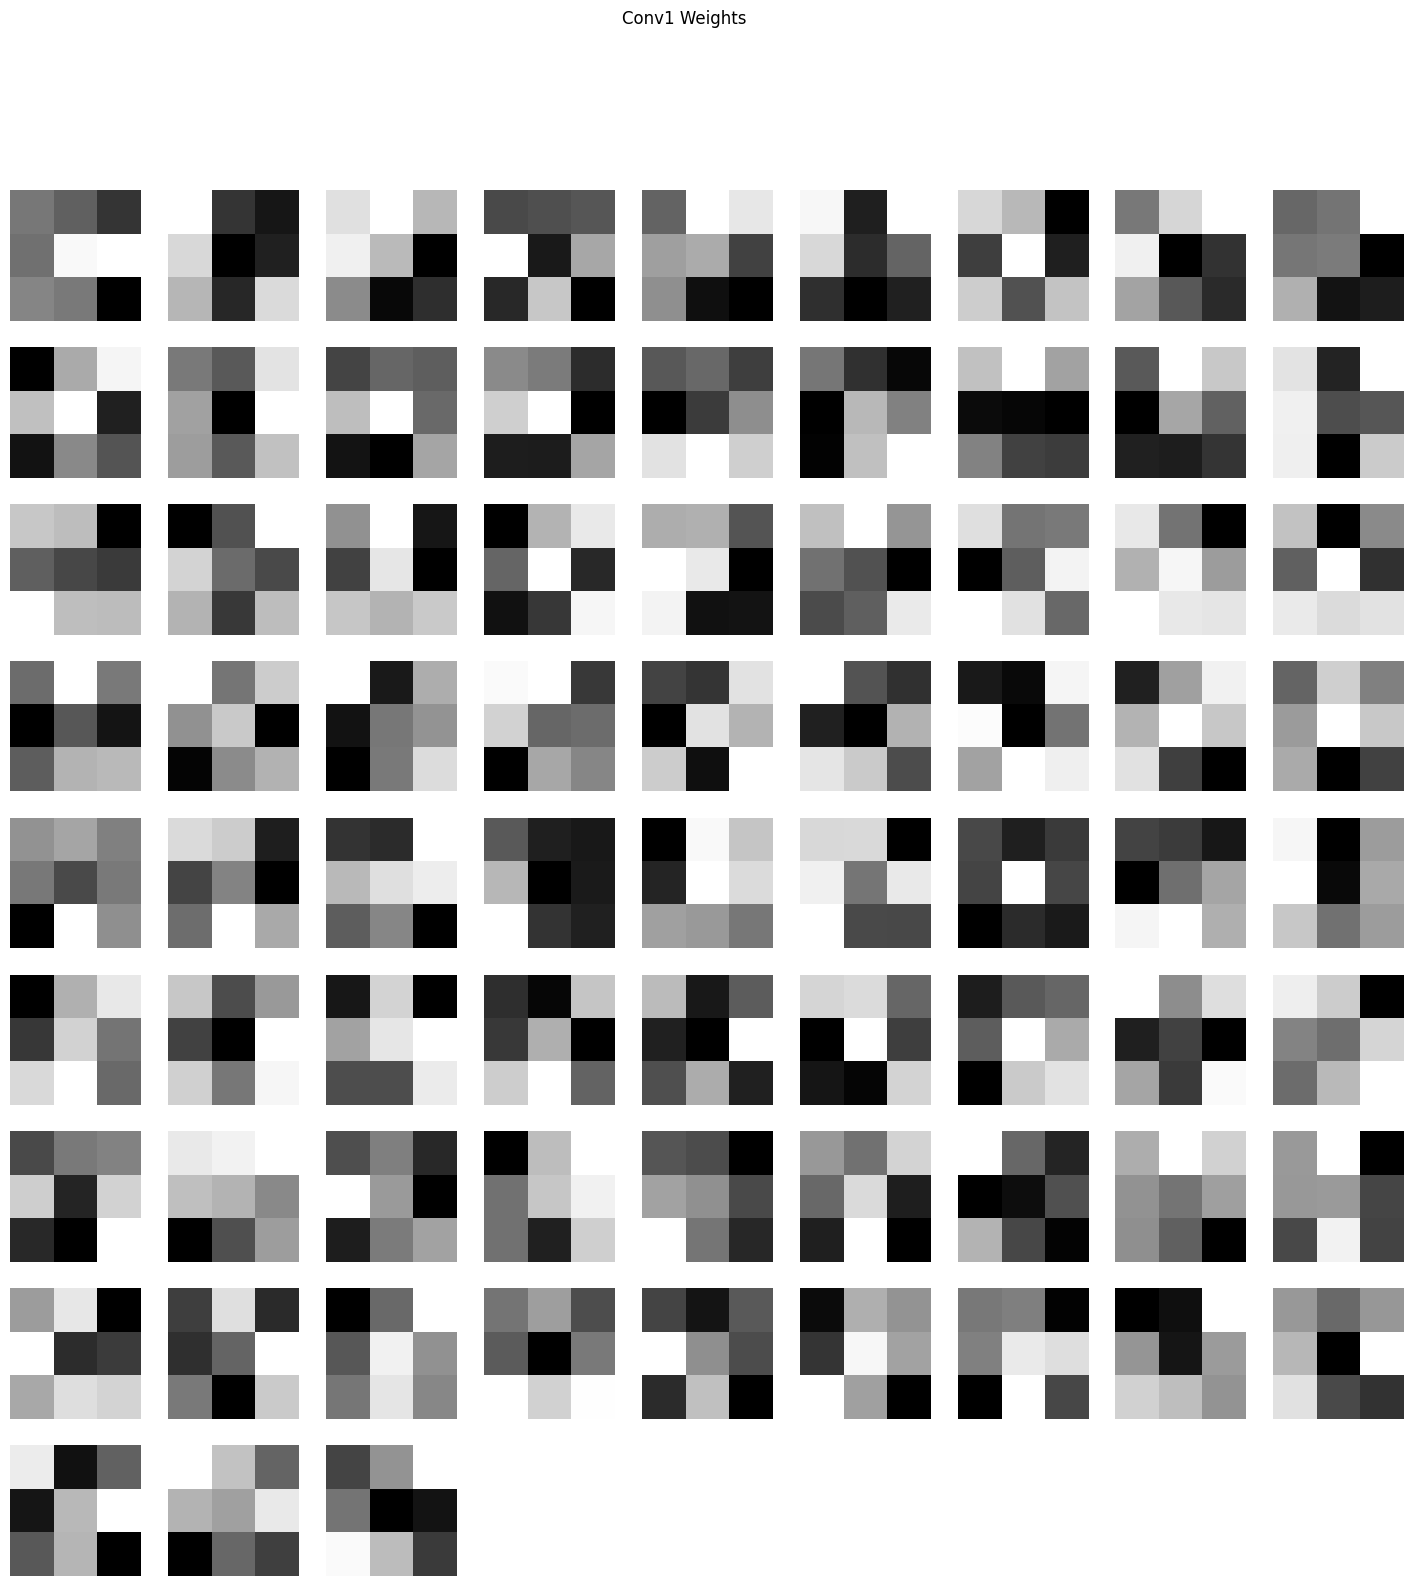

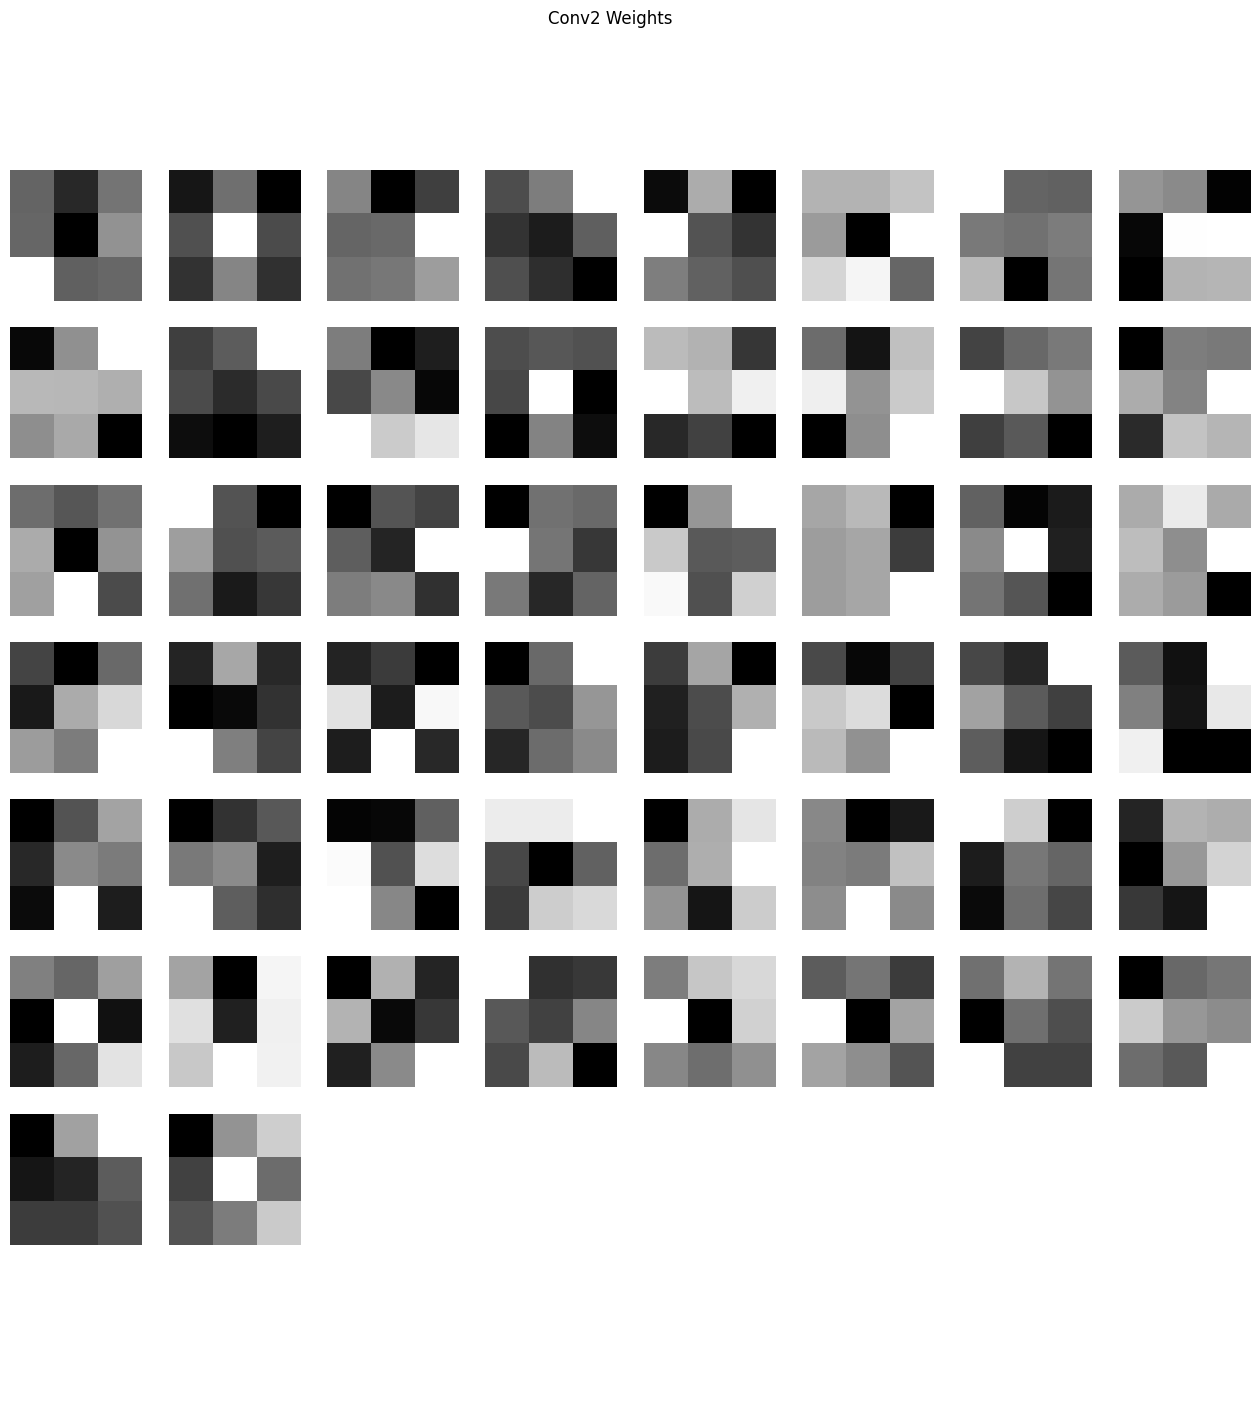

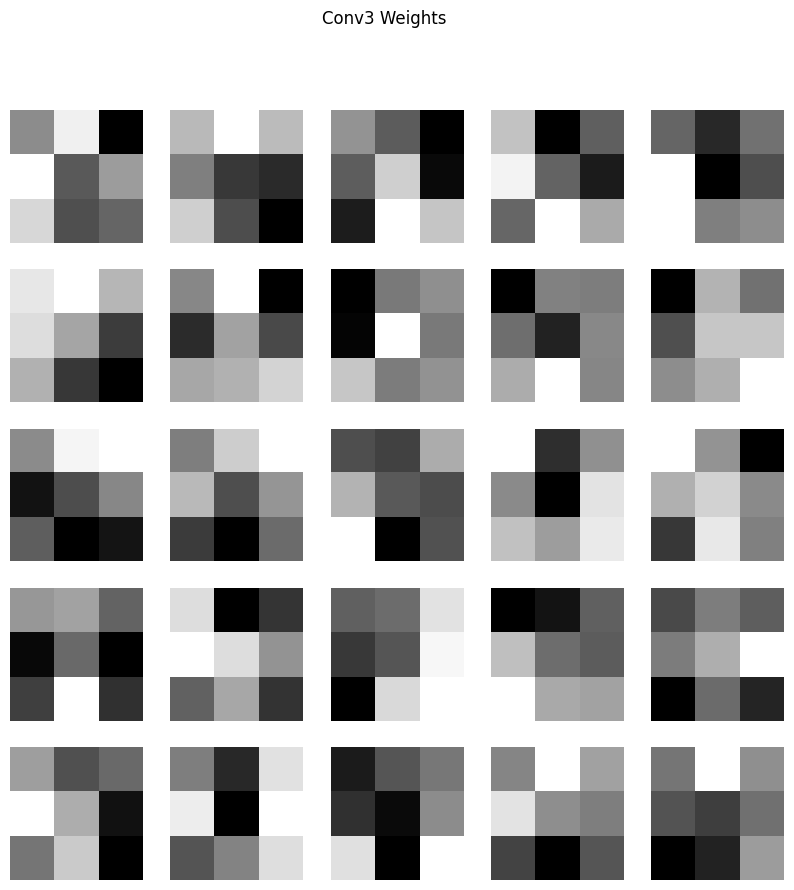

In [ ]:
# Affichage des poids des filtres de la première couche de convolution
conv1_weights = cnn.conv1.weight
visualize_conv_weights(conv1_weights, "Conv1 Weights")
# Affichage des poids des filtres de la 2e couche de convolution
conv2_weights = cnn.conv2.weight
visualize_conv_weights(conv2_weights, "Conv2 Weights")
# Affichage des poids des filtres de la 3e couche de convolution
conv3_weights = cnn.conv3.weight
visualize_conv_weights(conv3_weights, "Conv3 Weights")

[]
